# ***Can we predict abundance and distribution of mackerel catches between subareas of EU-waters as a spatially correlated timeseries problem?***

###### Kia Kafaei s153811, Stanley Frederiksen s140425, Frederik Bjare s082633

For this problem we want to analyze the data in the [ICES Fishmap database](http://ecosystemdata.ices.dk/map/index.aspx) which contains a 30 year long time series of 73.000 samples of no. of mackerels caught at various locations during scientific surveys. Using this data we want to make predictions at varios time intervals into the future.

In [1]:
#@title Install npyro and geopandas
!pip install numpyro
!pip install geopandas

     |████████████████████████████████| 163kB 3.5MB/s 
     |████████████████████████████████| 256kB 10.9MB/s 
     |████████████████████████████████| 25.4MB 172kB/s 
  Created wheel for jax: filename=jax-0.1.57-cp36-none-any.whl size=297709 sha256=c0a9c9b446c9fa03a9ed70f517612f0d22d02f689ceb97e74e9cb52a2c7bcf5b
  Stored in directory: /root/.cache/pip/wheels/8a/b4/75/859bcdaf181569124306615bd9b68c747725c60bfa68826378
  Created wheel for fastcache: filename=fastcache-1.1.0-cp36-cp36m-linux_x86_64.whl size=39198 sha256=ddcf44a2e9ed7fe6c7d58e9a238b375c4f001f1eee3a5a491c6d82cf3ee88ae5
  Stored in directory: /root/.cache/pip/wheels/6a/80/bf/30024738b03fa5aa521e2a2ac952a8d77d0c65e68d92bcd3b6
Successfully built jax fastcache
  Found existing installation: jax 0.1.67
    Uninstalling jax-0.1.67:
      Successfully uninstalled jax-0.1.67
  Found existing installation: jaxlib 0.1.47
    Uninstalling jaxlib-0.1.47:
      Successfully uninstalled jaxlib-0.1.47
     |███████████████████████████████

In [2]:
#@title Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode

import seaborn as sns
import plotnine as p9

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

from copy import deepcopy
import time
import geopandas

import io
from google.colab import files

# matplotlib style options
#plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#@title Upload the data file mackerel.csv
uploaded = files.upload()

Saving MackerelData.csv to MackerelData.csv


# Inspecting the data
The data set contains the no. of mackerel caught in scientific hauls from 1988 until 2019. The hauls are performed in a standardized way, and so should be comparable. Along with the no. of mackerel caught longtigtude, latitude and a timestamp is also given. Our hope is that this data contains information that can be used to predict future catches. 

Now, let's first have a look at the data we got and a few summary plots.

In [23]:
#@title Load data
df = pd.read_csv(io.BytesIO(uploaded['MackerelData.csv']))
df.head(5)

,dd-mm-yyyyThh:mm:ss,Longitude [degrees_east],Latitude [degrees_north],Depth [m],DataSet,Datatype,Parameter,Value,Precision,Unit,Species,Matrix,DEPHL,DEPHU,QFLAG,BASIS,Depth Class,Age Class,Length Class,Sex,DayNight,NOINP,Original Value,Original Unit,SampleID,MeasurementID,ICES Position Note,ICES DateTime Note
0,06/10/2010 13:45:00,-4.9423,54.2091,NaN,Fish trawl survey,Northern Ireland Ground Fish Survey,SPABUN,2.0,NaN,#,Scomber scombrus,NaN,NaN,NaN,NaN,NaN,17,NaN,265,NaN,D,2,NaN,NaN,8363549_223260_3095171,135740C14387835,NaN,NaN
1,06/10/2010 13:45:00,-4.9423,54.2091,NaN,Fish trawl survey,Northern Ireland Ground Fish Survey,SPABUN,4.0,NaN,#,Scomber scombrus,NaN,NaN,NaN,NaN,NaN,17,NaN,280,NaN,D,4,NaN,NaN,8363549_223260_3095171,135740C14387836,NaN,NaN
2,06/10/2010 13:45:00,-4.9423,54.2091,NaN,Fish trawl survey,Northern Ireland Ground Fish Survey,SPABUN,2.0,NaN,#,Scomber scombrus,NaN,NaN,NaN,NaN,NaN,17,NaN,290,NaN,D,2,NaN,NaN,8363549_223260_3095171,135740C14387837,NaN,NaN
3,06/10/2010 13:45:00,-4.9423,54.2091,NaN,Fish trawl survey,Northern Ireland Ground Fish Survey,SPABUN,2.0,NaN,#,Scomber scombrus,NaN,NaN,NaN,NaN,NaN,17,NaN,295,NaN,D,2,NaN,NaN,8363549_223260_3095171,135740C14387838,NaN,NaN
4,06/10/2010 13:45:00,-4.9423,54.2091,NaN,Fish trawl survey,Northern Ireland Ground Fish Survey,SPABUN,1.0,NaN,#,Scomber scombrus,NaN,NaN,NaN,NaN,NaN,17,NaN,300,NaN,D,1,NaN,NaN,8363549_223260_3095171,135740C14387839,NaN,NaN


From this we extract time, coordinates, and catch values (no. of mackerel caught in each specific haul).

In [24]:
#@title Extract relevant data
df = df.iloc[:,[0,2,7,1]]
df.columns=['Date','Latitude','Value','Longtitude']

df.Date=pd.to_datetime(df.Date)
df.head()

df = df[df.Date>'2000-01-01']
df.head()

,Date,Latitude,Value,Longtitude
0,2010-06-10 13:45:00,54.2091,2.0,-4.9423
1,2010-06-10 13:45:00,54.2091,4.0,-4.9423
2,2010-06-10 13:45:00,54.2091,2.0,-4.9423
3,2010-06-10 13:45:00,54.2091,2.0,-4.9423
4,2010-06-10 13:45:00,54.2091,1.0,-4.9423


# Spatial structure of data
Let's have a look at the data on a map. What we want to do is divide the data into subareas in order to make predictions for them individually. For this we hope that the data is well spread out and there's lots of it.

So the data was divided into 4  areas
No of observations pr. area
Area  0 :  6458
Area  1 :  8355
Area  2 :  21909
Area  3 :  31100


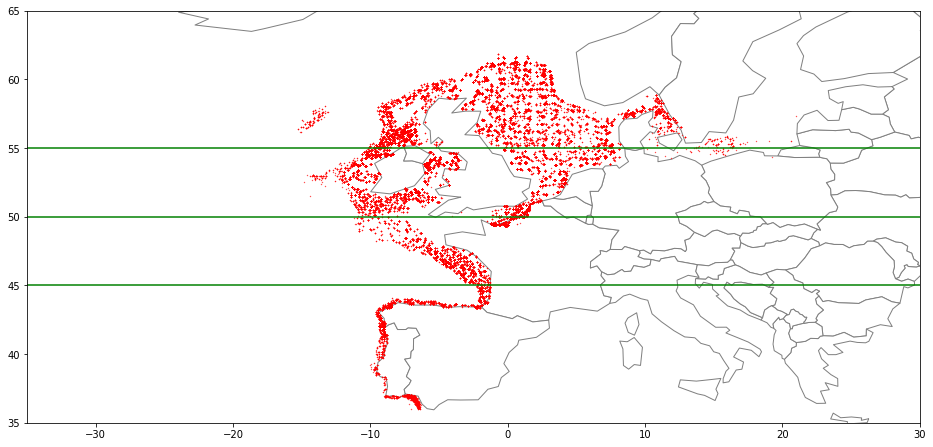

In [25]:
#@title Plot data on a map
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longtitude, df.Latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'Europe'].plot(
    color='white', edgecolor='grey')
ax.set_ylim(bottom = 35, top=65)
ax.set_xlim(left = -35, right = 30)

gdf.plot(ax=ax, color='red', markersize=0.1)

# Assign data to different areas


df['Area']=0
lats = np.append( np.array(range(45,60,5)), 90)
A = len(lats) #no of areas
lprev=0
i=0
for l in lats:
  df.loc[((df.Latitude<l) & (df.Latitude>=lprev)),"Area"]=i
  lprev=l
  i=i+1

print("So the data was divided into", A, " areas")
print('No of observations pr. area')
for i in range(A):
  print("Area ", i,": ",sum(df.Area==i))

ax.hlines(np.array(lats),-35,30,colors="green")


plt.show()

Ok, so we have divided the data into 4 areas (seperated by green lines) in order to make predictions for them individually. To make life simpler for ourselves, we have chosen to divide only along latitude.

So spatial resolution looks pretty good, but how about the temporal resolution?

Text(0.5, 1.0, 'Area 0')

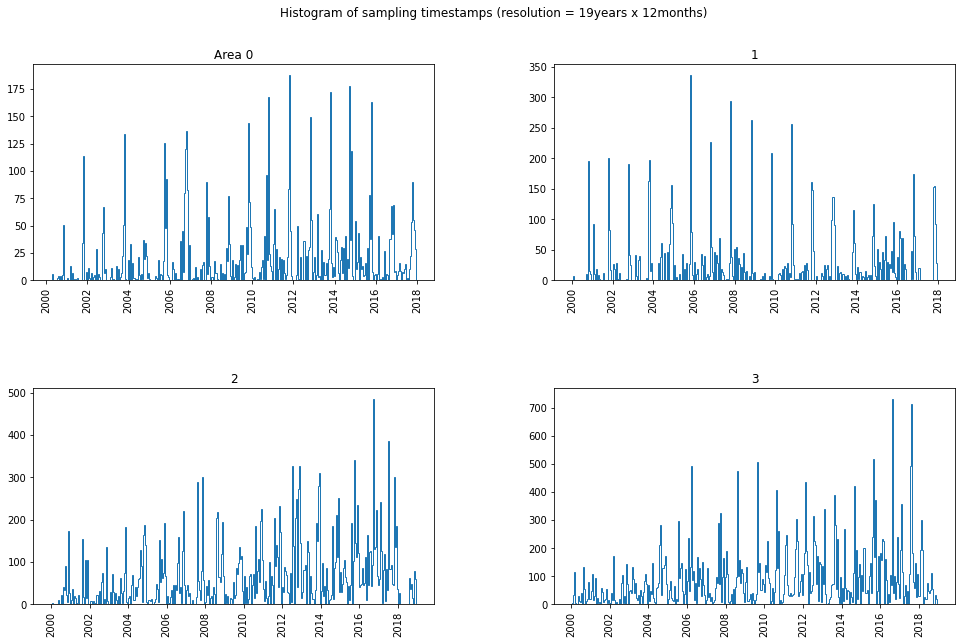

In [28]:
#@title Temporal resolution
#Alternative timestamps
df["monthday"]=df.Date.dt.month + df.Date.dt.day/30 #approximately right
df["month"]=df.Date.dt.month
df["day"]=df.Date.dt.day

#df.groupby('Area').plot(x='monthday', y='Value',ax=ax, legend=False,style="*")

#fig2, ax3 = plt.subplots()
#df.groupby('Area').hist(x='monthday',ax=ax3, legend=False)

fig, ax = plt.subplots(2,2)
df.hist(column="Date",by="Area",histtype=u'step',bins=30*12,ax=ax)
plt.suptitle("Histogram of sampling timestamps (resolution = 19years x 12months)")
ax[0,0].set_title("Area 0")

Above are histograms of timestamps through the last 30 years, with a binsize of one month. Certainly sampling has gotten more frequent in later years, and there seems to be times of year with much higher sampling intensity than others. Let's zoom in on the last five years to see if we can get a few more details.

Text(0.5, 0.98, 'Histogram of sampling timestamps 2013-2018 (resolution = 5years x 12months)')

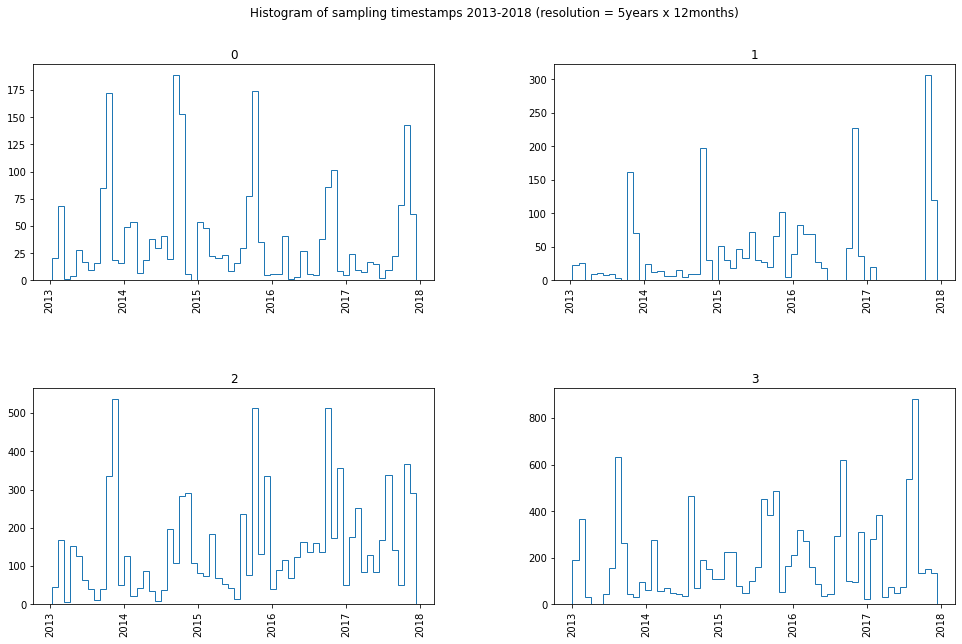

In [29]:
#@title Last five years
df5 = df[(df.Date>'2013-01-01') & (df.Date<'2018-01-01')]
df5.hist(column="Date",by="Area",histtype=u'step',bins=5*12)
plt.suptitle("Histogram of sampling timestamps 2013-2018 (resolution = 5years x 12months)")

With each bin representing a month the data coverage seems reasonable. Most months have at least 10-25 samples and many have several hundreds. Just a few periods (mostly in area 1) have no data at all. Looking only at this data set, a monthly resolution for our timeseries model might be reasonable. However, exactly how many points are required for each timestep also depends on how noisy the data is, and thus how many samples we need to get a reasonable reading of the signal.

Before we get to this, let's look at just a single year with 365 bins.

Text(0.5, 0.98, 'Histogram of sampling timestamps 2015 (resolution = 365 days)')

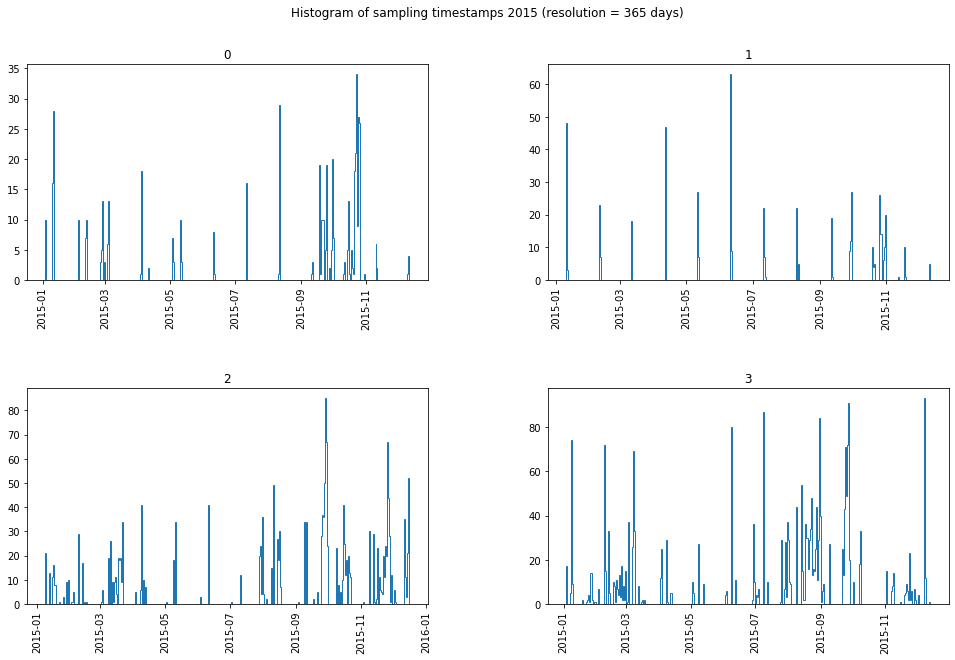

In [30]:
#@title Year 2015, 365 bins
df2015 = df[(df.Date>'2015-01-01') & (df.Date<'2016-01-01')]
df2015.hist(column="Date",by="Area",histtype=u'step',bins=365)
plt.suptitle("Histogram of sampling timestamps 2015 (resolution = 365 days)")

Ok, it definitely seems that sampling efforts are highly concentrated around specific times of the month, and so it looks like we should not aim for anything finer than monthly resolution.

# What the data shows
So far we have seen that the resolution we can reasonably expect from our timeseries model could be around 1 year for the entire data set or one month if we look at the later sections of the data set. At least as far as data coverage is concerned. However, this of course also depends on the actual values that we are trying to predict. Namely what does the distribution of no. of mackerel caught within each timestamp look like? how noisy is the data? is there any correlation between points that are close together in time?

Text(0.5, 0.98, 'Histogram of catch values for area-timestamp pairs (entire dataset, yearly resolutution)')

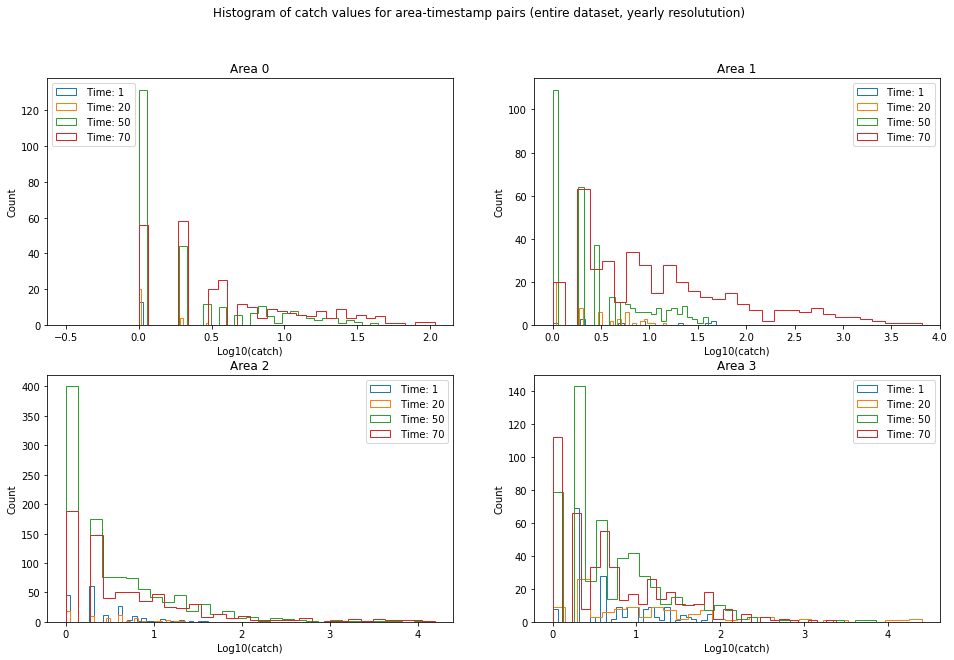

In [48]:
#@title histogram of catch values: 19 years and 4 yearly samples sampling
#Discretize time
T = 19*4
df['Time'] = pd.cut(df.Date,T,labels=range(T))
df.Time=df.Time.cat.codes

times=np.array([1, 20, 50, 70])
fig2, ax2 = plt.subplots(2, 2)
ax2=ax2.reshape(4)
for a in range(A):
  for t in times:
    ax2[a].hist( np.log10(df.Value[ np.logical_and( df.Time==t+1, df.Area == a )]) , bins = 30, histtype=u'step' )
    legs = [" Time: " + time for time in times.astype(str) ]
    ax2[a].legend(legs)
    ax2[a].set_title( 'Area ' + str(a) )
    ax2[a].set_xlabel("Log10(catch)")
    ax2[a].set_ylabel("Count")
fig2.suptitle("Histogram of catch values for area-timestamp pairs (entire dataset, yearly resolutution)")


The above histograms show no. of mackerel caught in a single haul within an area at a specific timestamp (1,10,20,28 years after timeseries start). The catch values are log10-transformed and even though some of the timestamps contain more data than other, they all seem to be following something like a geometric distribution or similar with a very high no. of very low catches (1 fish) and a few points with more than 10.000 fish landed. The high spread in the data suggests that no. of fish caught should not be expected to be a single hidden value for each timestamp (that is measured with some noise), but rather a distribution with a range of possible values for each measurement. Finding the parameters of this distribution should then be the goal of our model.

Now let's try to do the same for monthly data in the last five years.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Text(0.5, 0.98, 'Histogram of catch values for area-timestamp pairs (entire dataset, yearly resolutution)')

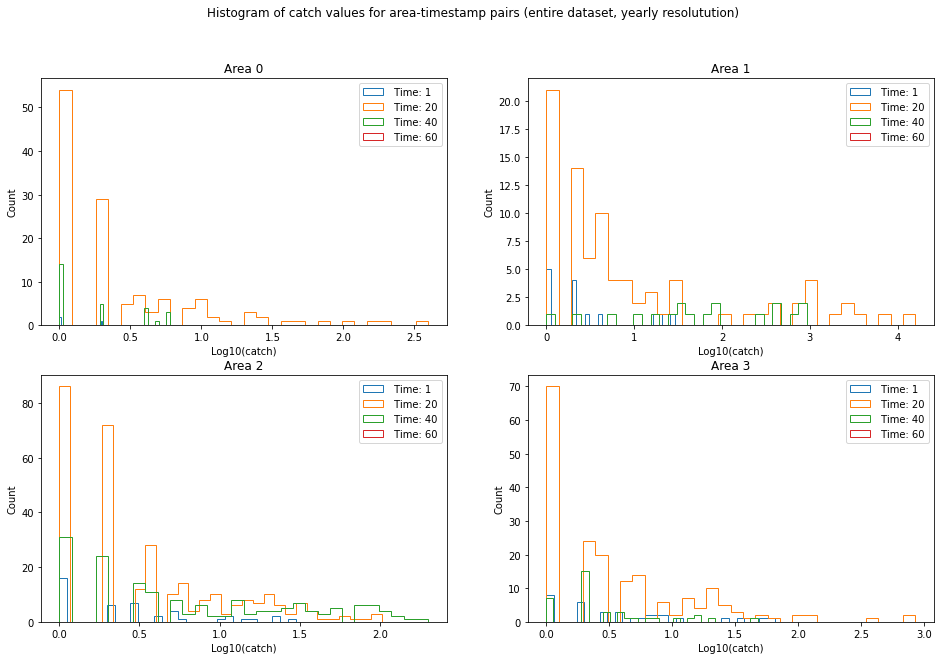

In [49]:
#@title histogram of catch values, five years monthly sampling
#Discretize time
T5 = 5*12
df5.loc[:,"Time"] = pd.cut(df5.Date,T5,labels=range(T5))
df5.loc[:,"Time"]=df5.Time.cat.codes


times=np.array([1, 20, 40, 60])
fig3, ax3 = plt.subplots(2, 2)
ax3=ax3.reshape(4)
for a in range(A):
  for t in times:
    ax3[a].hist( np.log10(df5.Value[ np.logical_and( df5.Time==t+1, df.Area == a )]) , bins = 30, histtype=u'step' )
    legs = [" Time: " + time for time in times.astype(str) ]
    ax3[a].legend(legs)
    ax3[a].set_title( 'Area ' + str(a) )
    ax3[a].set_xlabel("Log10(catch)")
    ax3[a].set_ylabel("Count")
fig3.suptitle("Histogram of catch values for area-timestamp pairs (entire dataset, yearly resolutution)")




Again, although there are fewer data points, the overall pattern seems roughly the same.

## Timeseries

Now let's try to have a look at the temporal dynamics of the data and see if this gives us any insights into how to model the data.

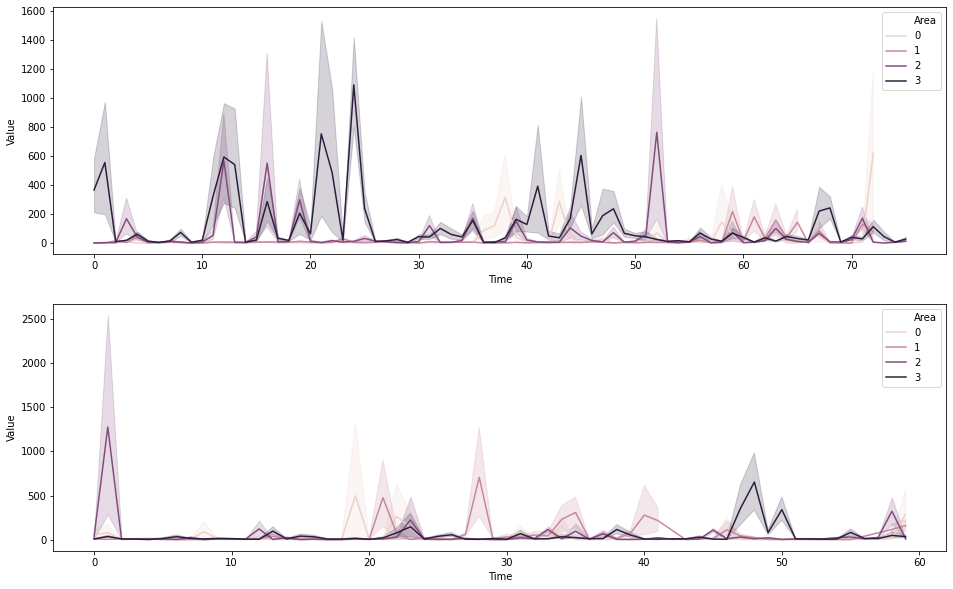

In [50]:
#@title Timeseries of means (19 years above, 5 years below)
fig, ax = plt.subplots(2,1)
#dfAgg = df.groupby(['Area', 'Time'],as_index=False)['Value'].mean()


sns.lineplot(data=df, x='Time', y='Value',estimator="mean", hue='Area',ax=ax[0])

df5Agg = df5.groupby(['Area', 'Time'],as_index=False)['Value'].mean()

sns.lineplot(data=df5, x='Time', y='Value', estimator="mean", hue='Area',ax=ax[1])


Above is plotted the mean of the data. Doesn't immediately look too promising! Now if we assume the data follows an exponential or geometric distribution, both of these would be characterised by a parameter which is 1/mean (lambda or p respectively). Lets try to plot the inverse of the mean and see if we have better luck.

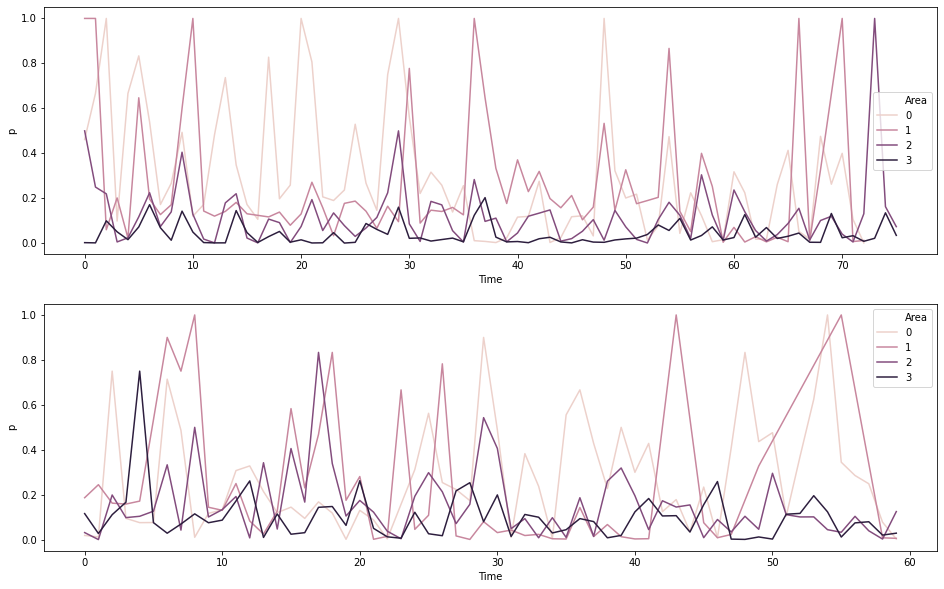

In [51]:
#@title Inverse mean timeseries
fig, ax = plt.subplots(2,1)
dfAgg = df.groupby(['Area', 'Time'],as_index=False)['Value'].mean()
dfAgg["p"] = 1/dfAgg["Value"]

sns.lineplot(data=dfAgg, x='Time', y='p', hue='Area',ax=ax[0])

df5Agg = df5.groupby(['Area', 'Time'],as_index=False)['Value'].mean()
df5Agg["p"] = 1/df5Agg["Value"]

sns.lineplot(data=df5Agg, x='Time', y='p', hue='Area',ax=ax[1])


Uh, still not too good. However, it does seem as if there is some correlation between the differen areas, so increases in one area is correlated with increases in other areas.

Before we move on to the model, let's have a look at the autocorrelation of the timeseries. If this is very weak or non-existent, perhaps we should consider alternative approaches!

Text(0.5, 1.0, 'Autocorrelation of means of 5 years timeseries')

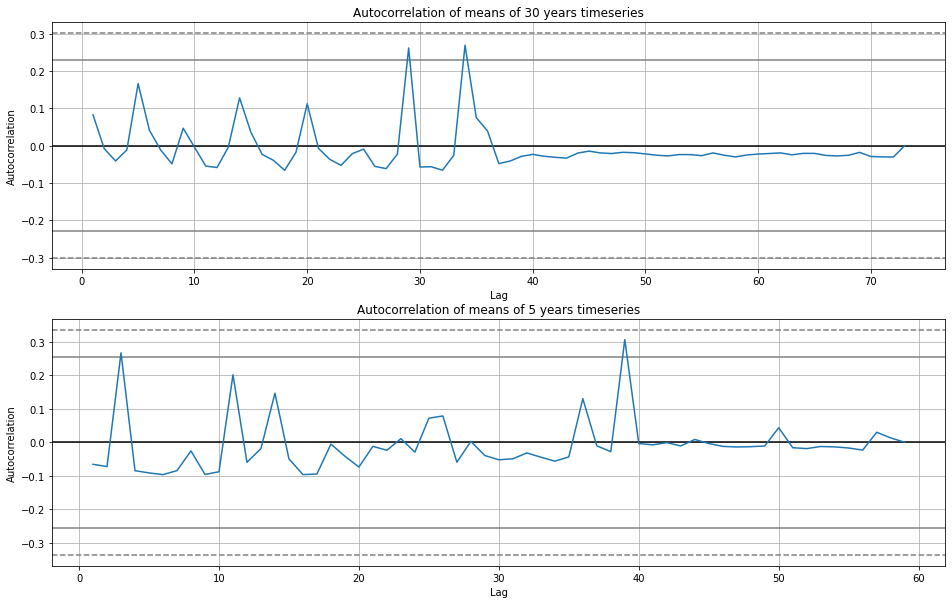

In [52]:
#@title Autocorrelation of means
fig,ax=plt.subplots(2,1)
pd.plotting.autocorrelation_plot(dfAgg.Value[dfAgg.Area==0],ax=ax[0])
ax[0].set_title('Autocorrelation of means of 30 years timeseries')
pd.plotting.autocorrelation_plot(df5Agg.Value[df5Agg.Area==0],ax=ax[1])
ax[1].set_title('Autocorrelation of means of 5 years timeseries')

Plottet above is the correlation between means of datapoints and means of previous data points at increasing lags. The solid grey lines represent 95% confidence intervals, and the dashed grey lines represent 99% confidence interval for normally distributed data with 0 correlation. Ideally for our idea of a timeseries model we should have seen some correlation with significant departure from normally distributed data!

In a desperate last push for the summit, let's try to do the same for the inverse means.

Text(0.5, 1.0, 'Autocorrelation of inverse means of 5 years timeseries')

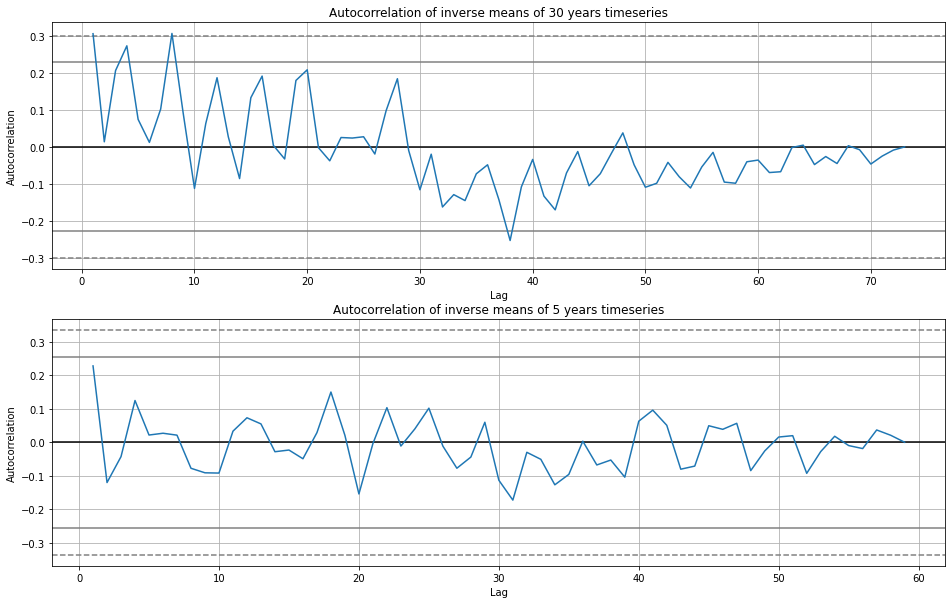

In [53]:
#@title Autocorrelation of inverse means
fig,ax=plt.subplots(2,1)
pd.plotting.autocorrelation_plot(dfAgg.p[dfAgg.Area==0],ax=ax[0])
ax[0].set_title('Autocorrelation of inverse means of 30 years timeseries')
pd.plotting.autocorrelation_plot(df5Agg.p[df5Agg.Area==0],ax=ax[1])
ax[1].set_title('Autocorrelation of inverse means of 5 years timeseries')

Again we don't see any significant departure from normality, although the trend seems slightly more consistent for the 30 years timeseries with perhaps some weak evidence of positive correlation with a lag of 5-6 years.

# ***Modeling***
Looking at the data, a time series does not immediately seem like the best approach as there appears to be a lot of variation within the data and only weak autocorrelation. In other words, it does seem as if we should look for external variables such as ocean temperature, depth, fishing pressure, ocean current etc., and use some flexible model that could also be used to identify most important variables such as regression tree or other.

However, this analysis was mostly done after we had implemented the model, and certainly long after we decided on the time series approach which we did very early on, so this is what we will present.

A good learning experience of getting to know the data better before starting on the actual model work!

# Spatially correlated time series
For more details about how the model is derived see the Report.



# Resampling of data
As the no. of samples taken for each area,time-pair is highly varying, and because we do not want to use all 700000+ data points for all model runs, we decided to resample the data before giving it to the model. So for each area-time-pair we randomly select (with replacement) 10 data points.


In [54]:
#@title Resample data
# Resample data
np.random.seed(42)
n = 10 # no of data points to sample pr area-time coordinate
yRs = np.empty([T,A,n])
for a in range(A):
  for t in range(T):
     ys = df.Value[np.logical_and(df.Area==a, df.Time==t)]
     if len(ys)==0:
       ys = np.empty(n)
       ys[:] = np.nan
     else:
       ys = np.random.choice(ys, size=n)
     
     yRs[t,a,:] = ys

# Resample data
n = 10 # no of data points to sample pr area-time coordinate
y5Rs = np.empty([T5,A,n])
for a in range(A):
  for t in range(T5):
     ys = df5.Value[np.logical_and(df5.Area==a, df5.Time==t)]
     if len(ys)==0:
       ys = np.empty(n)
       ys[:] = np.nan
     else:
       ys = np.random.choice(ys, size=n)
     
     y5Rs[t,a,:] = ys

print("dimension of 30 years timeseries:",yRs.shape)
print("Percent missing data by area (30 years series)")
print(np.sum(np.isnan(yRs),axis=(0,2))/(T*n)*100)

print("dimension of 5 years timeseries:",y5Rs.shape)
print("Percent missing data by area (5 years series)")
print(np.sum(np.isnan(yRs),axis=(0,2))/(T5*n)*100)

dimension of 30 years timeseries: (76, 4, 10)
Percent missing data by area (30 years series)
[3.94736842 6.57894737 0.         0.        ]
dimension of 5 years timeseries: (60, 4, 10)
Percent missing data by area (5 years series)
[5.         8.33333333 0.         0.        ]


Now the question is what to do with the missing data. Of course we could let the model impute it (which we have also done), but unfortunately the model at this point produces too unreliable results to use this approach, which mean that the predictions will be worse than they could have been. We will therefore start by filling the missing data in with means and adding a bit of noise.

In [0]:
#@title Fill in missing data
# Fill in missing data with median
yRsMissing = np.isnan(yRs)
yRs[yRsMissing] = np.random.normal(loc=np.nanmedian(yRs)+2, scale = 1, size=np.sum(np.isnan(yRs),axis=(0,1,2)) )

y5RsMissing = np.isnan(y5Rs)
y5Rs[y5RsMissing] = np.random.normal(loc=np.nanmedian(y5Rs)+2, scale = 1, size=np.sum(np.isnan(y5Rs),axis=(0,1,2)) )

Now we define training and test set for the model and scale according to maximum catch so the data is 0

In [0]:
#@title Define train and test set
# Define train and test set
Ntrain = int(np.floor(0.8*T))
Ntest  = T-Ntrain

Ttrain = range(Ntrain)
Ttest  = range(Ntrain,T)

yRsTrain = yRs[Ttrain,:,:]
yRsTest  = yRs[Ttest,:,:]

#We dont want by feature scaling. We want to scale according to same value since samples from different areas are comparable
scaler = MinMaxScaler()
yRsTrain = scaler.fit_transform(yRsTrain.reshape(-1, yRsTrain.shape[-1])).reshape(yRsTrain.shape)
yRsTest = scaler.transform(yRsTest.reshape(-1, yRsTest.shape[-1])).reshape(yRsTest.shape)
#yRsTrain = (yRsTrain)/yRs.max()
#yRsTest = (yRsTest)/yRs.max()

ix_obs = np.array(Ttrain)
ix_mis = None
obs = yRsTrain[:]

# Now the same for 5 year series
N5train = int(np.floor(0.8*T5))
N5test  = T5-N5train

T5train = range(N5train)
T5test  = range(N5train,T5)

y5RsTrain = y5Rs[T5train,:,:]
y5RsTest  = y5Rs[T5test,:,:]

y5RsTrain = (y5RsTrain-y5Rs.mean())/y5Rs.max()
y5RsTest = (y5RsTest-y5Rs.mean())/y5Rs.max()

ix_obs5 = np.array(T5train)
ix_mis5 = None
obs5 = y5RsTrain[:]



Finally it's time to define the model - at this point with only the spatial correlation parameter (beta0) and one timestep back (beta1).

In [0]:
#MODEL - one timeseries no missing data
def f(carry, noise_t):
  SC, beta1, z_prev1, tau = carry
  # Due to fatser computation we will use SC* defined as SC* = jnp.linalg.inv((jnp.ones(shape=SC.shape) - SC))
  z_t = jnp.matmul( (beta1*z_prev1 + noise_t), SC ) + noise_t
  SC, beta1, z_prev1, tau = carry
  
  z_prev1 = z_t# z_prev2
  #z_prev2 = z_t

  return (SC, beta1, z_prev1, tau), z_t

from torch.distributions import constraints
import numpy

def model2(T, T_forecast, A, n, obs=None, ix_mis=None, ix_obs=None):

    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    SC = numpyro.sample(name="SC", fn=dist.Normal(loc=jnp.zeros([A,A]), scale=1*jnp.ones(A)))
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=jnp.zeros(A), scale=1*jnp.ones(A)))
    #beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=jnp.zeros(A), scale=1*jnp.ones(A)))

    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(A)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(A), scale=jnp.ones(A)))
    #z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=jnp.zeros(A), scale=jnp.ones(A)))

    # Define LKJ prior
    #L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(A, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), jnp.eye(A)) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(A), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))#-2,))#-2,))
    #print(Sigma_lower)
#print()

    # Propagate the dynamics forward using jax.lax.scan
    carry = (SC, beta1, z_prev1, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-1)#-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    z_obs_rep = jnp.repeat(z_collection[ix_obs,:,jnp.newaxis],n,axis=2)

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_obs_rep, scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:,:], scale=sigma), obs=None)
    
    #numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)

    return z_collection

And let's go, using MCMC, 2000 samples and 1000 warmups

In [59]:
#@title Let's go, 19 years timeseries
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model2, step_size=0.3)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)

mcmc.run(rng_key_, T=Ntrain, T_forecast=Ntest, A=A, n=n, obs=obs, ix_mis=ix_mis, ix_obs=ix_obs)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))


sample: 100%|██████████| 3000/3000 [01:18<00:00, 38.39it/s, 255 steps of size 1.82e-02. acc. prob=0.83]


Total time: 1.534m


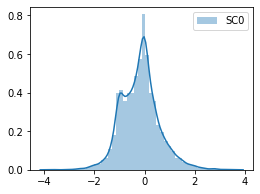

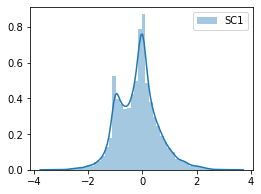

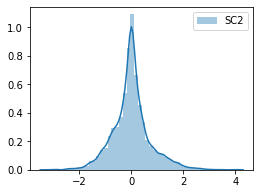

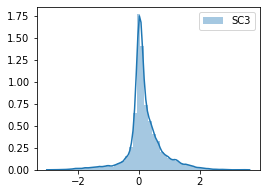

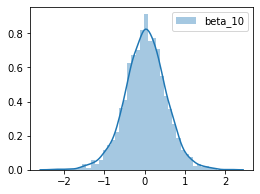

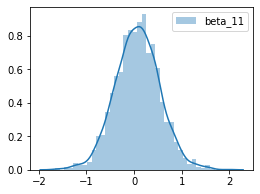

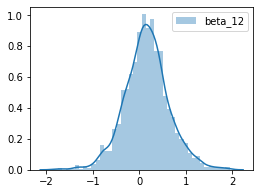

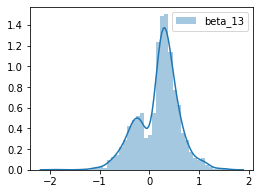

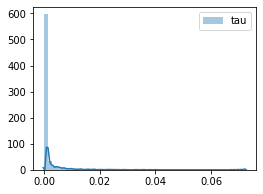

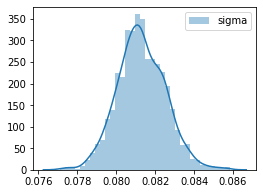

In [61]:
#@title Visualize model 19 years
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["SC","beta_1", "tau", "sigma"]
for node in nodes:
  if (node == "SC" or node == "beta_1" or node=="beta_2"):
    for i in range(A):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

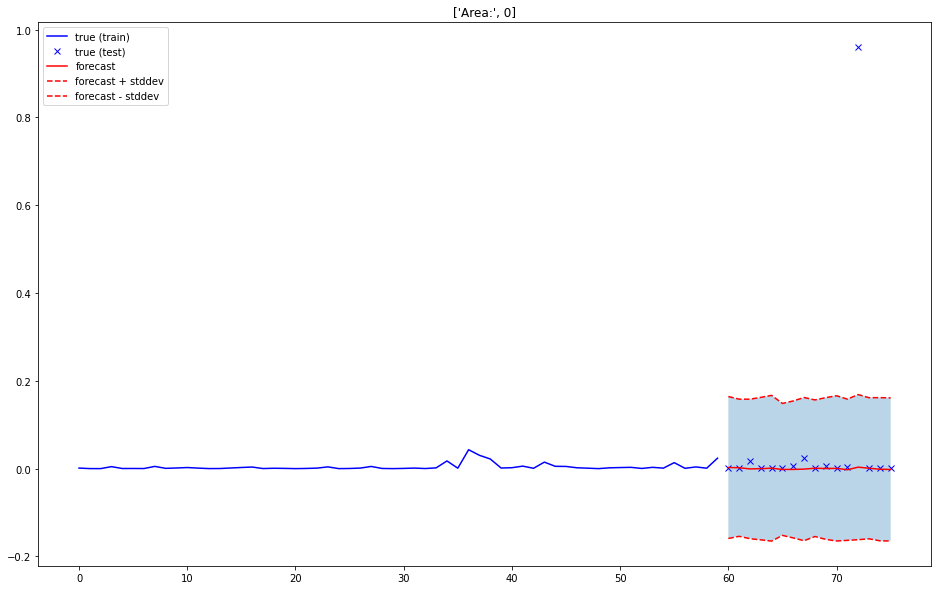

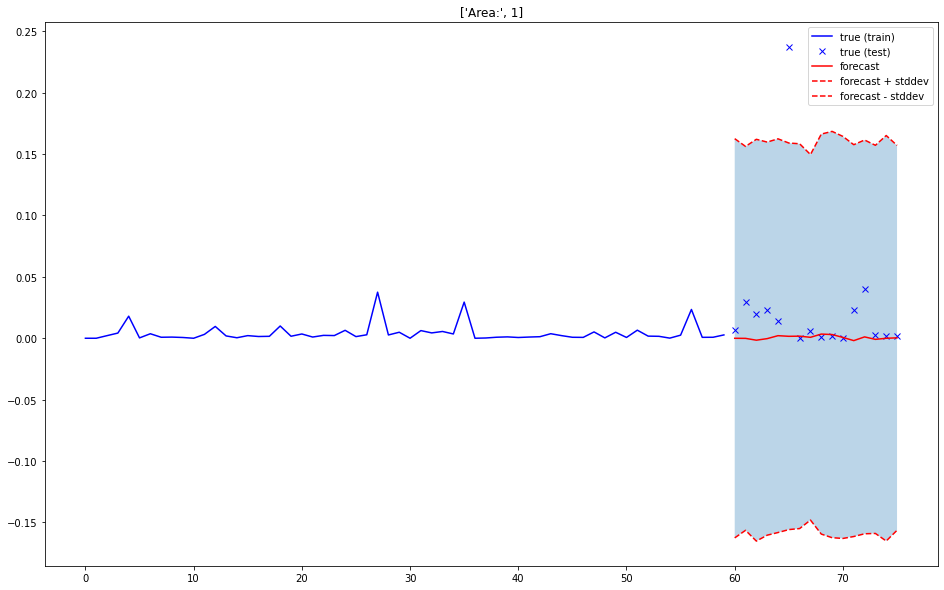

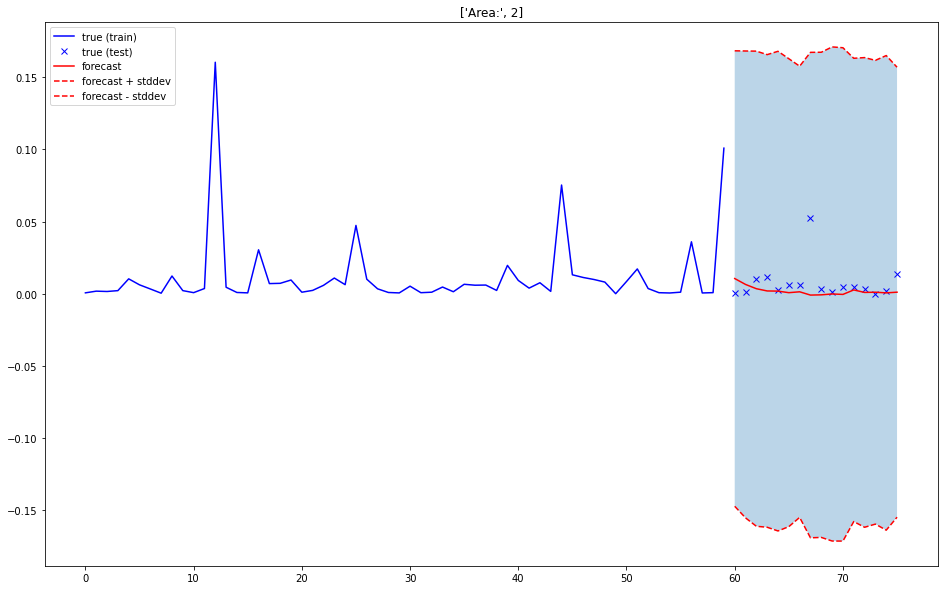

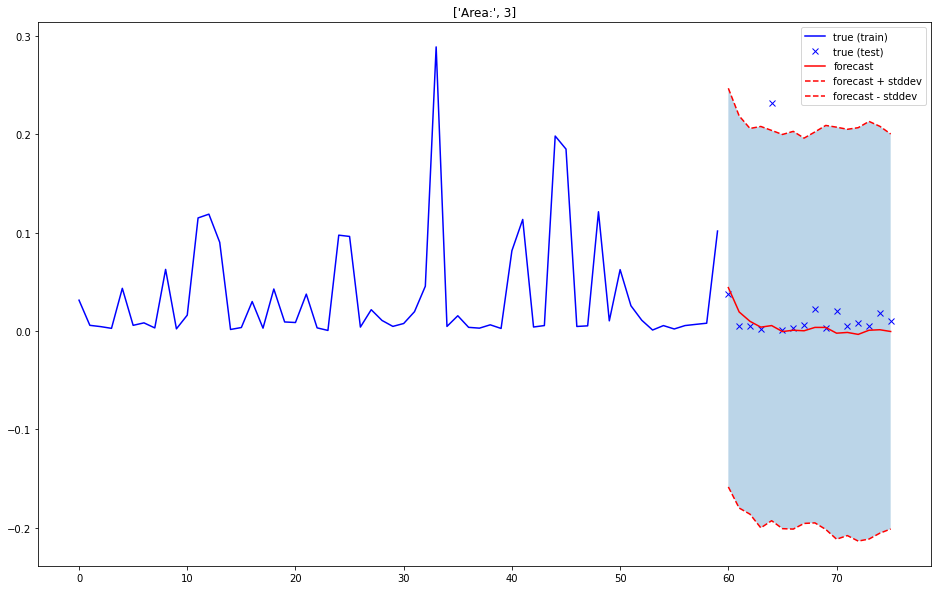

In [62]:
#@title Predict and plot 19 years
for a in range(A):
  q1 = hmc_samples["y_pred"][:,:,a]
  q1_mean = q1.mean(axis=0).reshape(-1,)
  q1_std = q1.std(axis=0).reshape(-1,)
  y1_pred_025 = q1_mean - 1.96*q1_std
  y1_pred_975 = q1_mean + 1.96*q1_std
  y1_pred_mean = q1_mean

  plt.plot(Ttrain[-80:], np.mean(yRsTrain[-80:, a,:], axis=1), "b-")
  plt.plot(Ttest, np.mean(yRsTest[:, a,:], axis=1), "bx")
  plt.plot(Ttest, y1_pred_mean, "r-")
  plt.plot(Ttest, y1_pred_025, "r--")
  plt.plot(Ttest, y1_pred_975, "r--")
  plt.fill_between(Ttest, y1_pred_025, y1_pred_975, alpha=0.3)
  plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
  plt.title(["Area:",a])
  plt.show()

In [43]:
#@title Let's go, 5 years timeseries
t0 = time.time()

rng_key5 = random.PRNGKey(0)
rng_key5, rng_key_5 = random.split(rng_key5)

nuts_kernel5 = NUTS(model=model2, step_size=0.05)
mcmc5 = MCMC(nuts_kernel5, num_samples=2000, num_warmup=1000, num_chains=1)

mcmc5.run(rng_key_5, T=N5train, T_forecast=N5test, A=A, n=n, obs=obs5, ix_mis=ix_mis5, ix_obs=ix_obs5)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))


sample: 100%|██████████| 3000/3000 [01:49<00:00, 27.50it/s, 255 steps of size 1.25e-02. acc. prob=0.80]


Total time: 2.124m


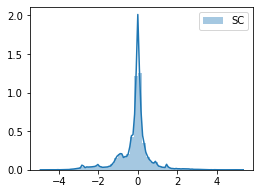

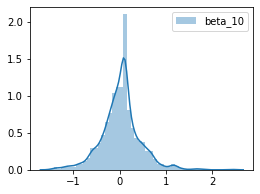

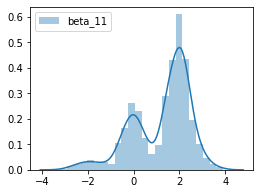

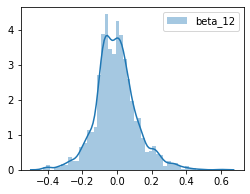

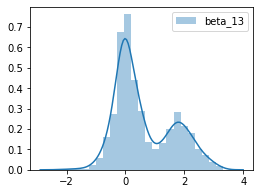

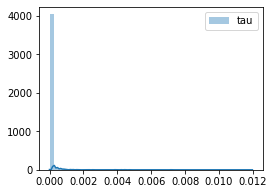

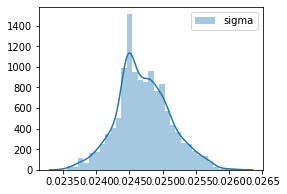

In [46]:
#@title Visualize model 5 years
hmc5_samples = {k: v for k, v in mcmc5.get_samples().items()}
nodes5 = ["SC","beta_1", "tau", "sigma"]
for node in nodes5:
  if (node == "beta_0" or node == "beta_1" or node=="beta_2"):
    for i in range(A):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc5_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc5_samples[node], label=node)
    plt.legend()
    plt.show()

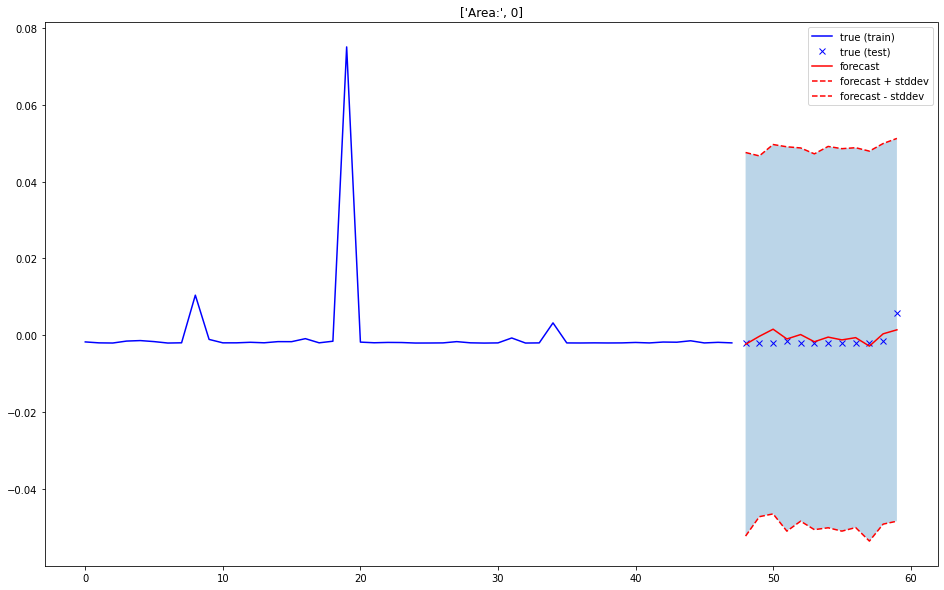

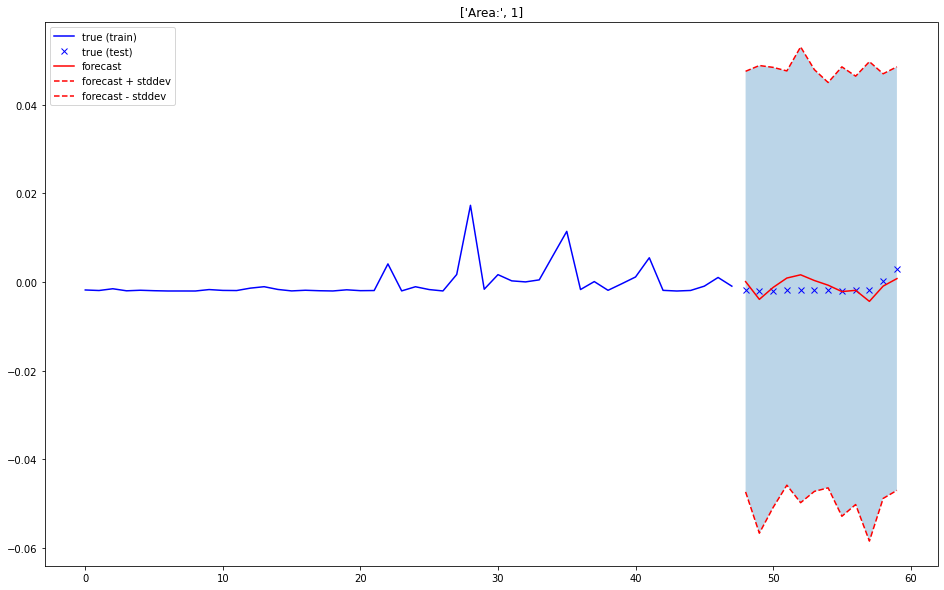

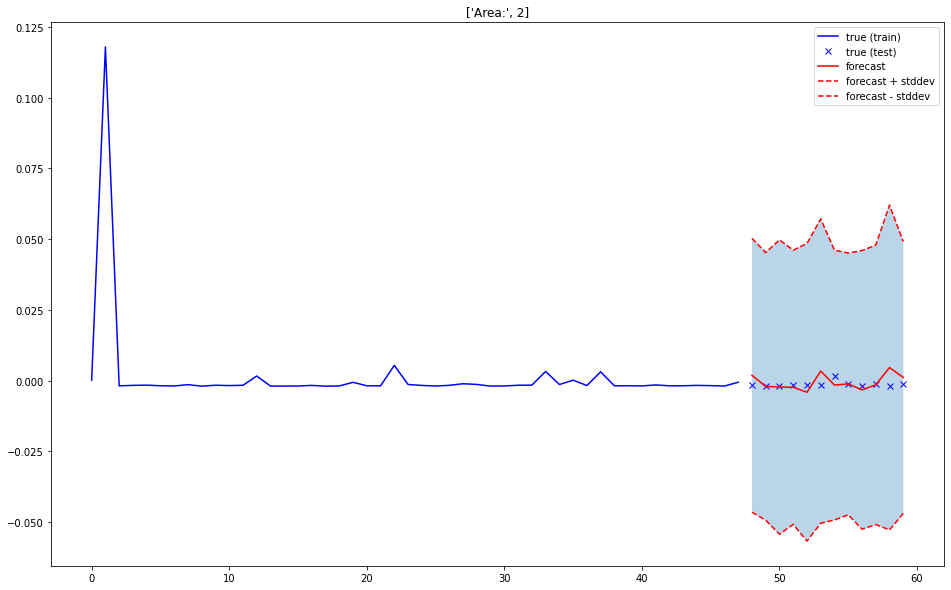

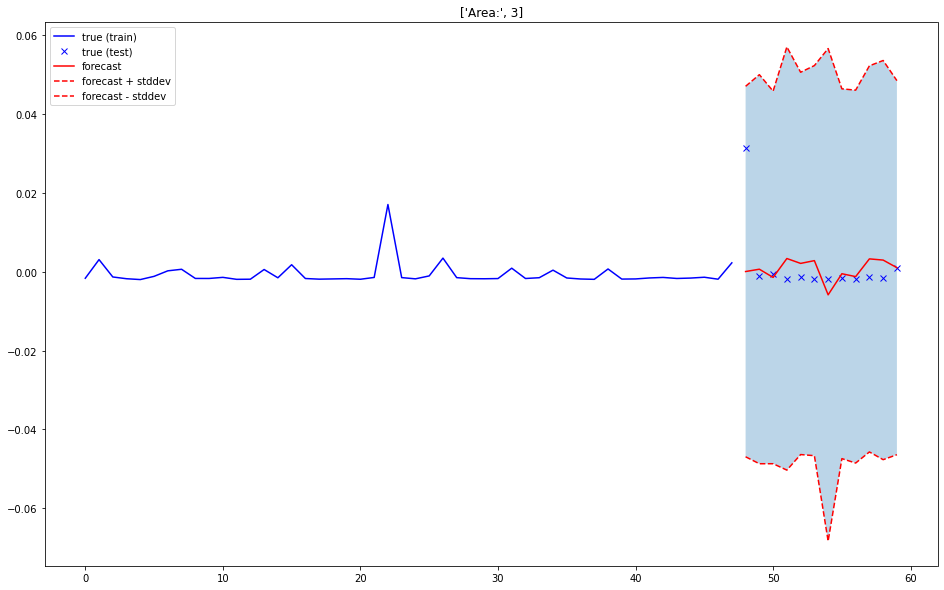

In [47]:
#@title Predict and plot 5 years
for a in range(A):
  q1 = hmc5_samples["y_pred"][:,:,a]
  q1_mean = q1.mean(axis=0).reshape(-1,)
  q1_std = q1.std(axis=0).reshape(-1,)
  y1_pred_025 = q1_mean - 1.96*q1_std
  y1_pred_975 = q1_mean + 1.96*q1_std
  y1_pred_mean = q1_mean

  plt.plot(T5train[-80:], np.mean(y5RsTrain[-80:, a,:], axis=1), "b-")
  plt.plot(T5test, np.mean(y5RsTest[:, a,:], axis=1), "bx")
  plt.plot(T5test, y1_pred_mean, "r-")
  plt.plot(T5test, y1_pred_025, "r--")
  plt.plot(T5test, y1_pred_975, "r--")
  plt.fill_between(T5test, y1_pred_025, y1_pred_975, alpha=0.3)
  plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
  plt.title(["Area:",a])
  plt.show()

Not too good. Let's see if we can include some external variables.